In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
from pysfa import *

## Import data

In [2]:
df = pd.read_csv('../data/msfa_data.csv')

## Create object

Our model can be written as,
$$
y_i = X_i \beta + u_i - v_i + \epsilon_i.
$$

where $u_i \sim N(0, \gamma)$ and $v_i \sim HN(0, \delta)$.

In [3]:
m = df.shape[0]
s = np.sqrt(df['uhc_variance'].values)
#
x = df['physicians'].values
z = np.ones((m,1))
d = np.ones((m,1))
y = df['uhc'].values
#
ind = np.argsort(x)
x = x[ind]
y = y[ind]
#
sfa = SFA(x.reshape(m,1), z, d, s, Y=y, add_intercept_to_x=True)

number of studies:      5460
number of measurements: 5460
dimension of beta:      2
dimension of gama:      1
dimension of deta:      1
cond number of X cov:   25.269134561075138
cond number of Z cov:   1.0
cond number of D cov:   1.0


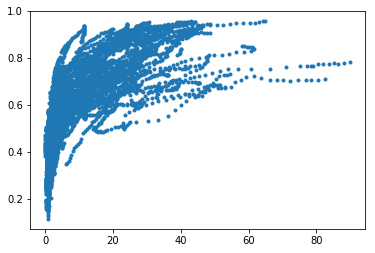

In [4]:
plt.plot(x, sfa.Y, '.')

## Add BSpline

Need to specify
* `knots`
* `degree`
* `l_linear`(linear head) and `r_linear` (linear tail)
* `bspline_mono`: curve increasing or decreasing
* `bspline_cvcv`: curve convex or concave

In [5]:
# add splines
knots = np.array([np.min(x), 20.0, 40.0, np.max(x)])
degree = 3
sfa.addBSpline(knots, degree, r_linear=True, bspline_mono='increasing', bspline_cvcv='concave')

## Add Constraints for the Variables

* constrain `beta` be between 0 and 1, so that the curve will be between 0 and 1
* constrain `gama` to be 0, so that $u_i$ in the equation will be 0
* constrain `deta` be be positive since it represent vairance of $v_i$

In [6]:
beta_uprior = np.array([[0.0]*sfa.k_beta, [1.0]*sfa.k_beta])
gama_uprior = np.array([[0.0]*sfa.k_gama, [0.0]*sfa.k_gama])
deta_uprior = np.array([[0.0]*sfa.k_deta, [np.inf]*sfa.k_deta])

sfa.addUPrior(beta_uprior, gama_uprior, deta_uprior)

## Fit data

In [7]:
sfa.optimizeSFA()

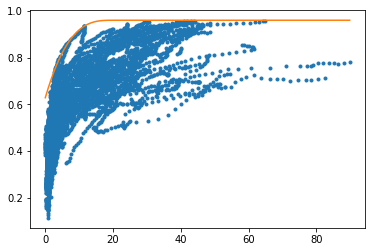

In [8]:
plt.plot(x, sfa.Y, '.')
plt.plot(x, sfa.X.dot(sfa.beta_soln))

## Estimate Random Effect

In [9]:
# call estimateRE function
sfa.estimateRE()

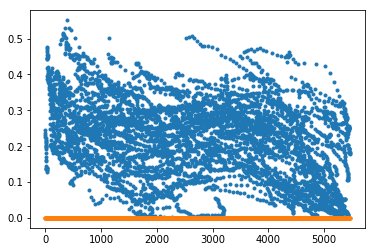

In [10]:
plt.plot(sfa.v_soln, '.')
plt.plot(sfa.u_soln, '.')

## Forcast Data Point

Extrapolate the data using `forcastData` function. Need to provide
* new `X`
* predicted `v` corresponding to the new `X`

In [11]:
x_new = x.copy()
X_new = x_new.reshape(x.size, 1)
# pretend the predict v value to be 0.1
v_new = sfa.v_soln.copy()

In [12]:
# call forcastData function
y_new = sfa.forcastData(X_new, v_new, add_intercept_to_x=True)

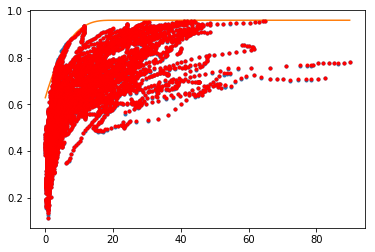

In [13]:
plt.plot(x, sfa.Y, '.')
plt.plot(x, sfa.X.dot(sfa.beta_soln))
plt.plot(x_new, y_new, '.r')

## Trimming SFA

In [14]:
sfa.optimizeSFAWithTrimming(int(0.9*sfa.N), stepsize=100.0, verbose=True, max_iter=20)

trim 0.100 of the data
iter    1, obj -3.86e+03, err 2.21e-01
iter    2, obj -3.98e+03, err 6.17e-02
iter    3, obj -4.16e+03, err 7.63e-02
iter    4, obj -4.32e+03, err 6.47e-02
iter    5, obj -4.52e+03, err 6.74e-02
iter    6, obj -4.62e+03, err 7.53e-02
iter    7, obj -4.67e+03, err 5.99e-02
iter    8, obj -4.72e+03, err 6.12e-02
iter    9, obj -4.77e+03, err 5.72e-02
iter   10, obj -4.81e+03, err 6.15e-02
iter   11, obj -4.88e+03, err 5.98e-02
iter   12, obj -4.93e+03, err 6.99e-02
iter   13, obj -4.96e+03, err 6.15e-02
iter   14, obj -4.99e+03, err 5.81e-02
iter   15, obj -5.04e+03, err 5.87e-02
iter   16, obj -5.12e+03, err 6.65e-02
iter   17, obj -5.19e+03, err 5.73e-02
iter   18, obj -5.22e+03, err 6.10e-02
iter   19, obj -5.23e+03, err 4.74e-02
iter   20, obj -5.24e+03, err 4.35e-02
trimming reach maximum number of iterations


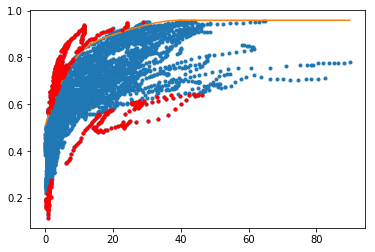

In [15]:
id_outliers = np.where(sfa.w == 0.0)[0]
plt.plot(x, y, '.')
plt.plot(x, sfa.X.dot(sfa.beta_soln))
plt.plot(x[id_outliers], y[id_outliers], 'r.')

In [16]:
np.sqrt(sfa.deta_soln)

array([0.1593902])

## Post Analysis

In [17]:
beta_sample, re_sample, y_sample, y_mean, y_negp, y_intv = predictData(sfa, include_random_effect=True, sample_size=100)

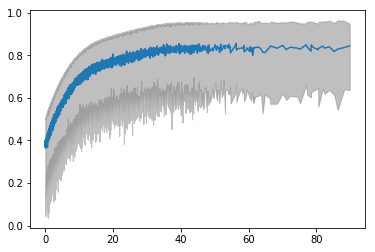

In [18]:
plt.plot(x, y_mean)
plt.fill_between(x, y_intv[:,0], y_intv[:,1], color='gray', alpha=0.5)

In [19]:
sfa.X.shape

(5460, 5)

In [20]:
sfa.beta_soln.shape

(5,)